1. 使用真实文本数据集(Huggingface mikasenghaas/wikitext-2)
2. 使用 GPT2 实现文本编码/解码

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
from typing import Optional, List, Tuple
from transformers import GPT2Tokenizer, default_data_collator
from datasets import load_dataset

import os

In [ ]:
# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# 本地模型路径
gpt2_model_path = "/ai/shenwei/workspace/Models/huggingface/gpt2"
# 本地数据集路径
dataset_path = "/ai/LLM_DATA/huggingface/wikitext"

In [ ]:
# 数据预处理
class WikiTextDataset(Dataset):
    def __init__(self, split="train", seq_len=128):
        super().__init__()
        # 加载 GPT2 分词器
        if not os.path.exists(gpt2_model_path):
            self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        else:
            self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_path)
        # pad token
        self.tokenizer.pad_token = self.tokenizer.eos_token

        # 加载wikitext-2数据集
        if not os.path.exists(dataset_path):
            self.dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split=split)
        else:
            self.dataset = load_dataset(dataset_path, split=split)
        # 数据预处理
        self.dataset = self.dataset.filter(lambda x: len(x["text"]) > 0 and not x["text"].isspace())  # 过滤掉空文本

        # 编码并拼接文本
        self.all_tokens = []
        for text in tqdm(self.dataset["text"], desc="Encoding text"):
            tokens = self.tokenizer.encode(
                text,
                add_special_tokens=True,
                truncation=False
            )
            self.all_tokens.extend(tokens)
        
        # 生成固定长度的样本数据
        self.samples = []
        for i in range(0, len(self.all_tokens) - seq_len, seq_len):
            self.samples.append(self.all_tokens[i:i + seq_len])
        print(f"数据集处理完成 | 总样本数: {len(self.samples)} | 序列长度: {seq_len}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.long)

wike_data = WikiTextDataset(split="validation", seq_len=128)
data_loader = DataLoader(wike_data, batch_size=8, shuffle=False, pin_memory=True)
# 打印 sample data
for batch in data_loader:
    print(batch)
    print(len(batch))
    break


In [ ]:
# 神经长期记忆(NLTM)模型
class NeuralLongTermMemory(nn.Module):
    def __init__(self, d_model: int, hidden_dim: int = 512, forget_gate_init: float = 0.9):
        super().__init__()
        self.d_model = d_model
        self.hidden_dim = hidden_dim

        # 惊喜度量
        self.surprise_momentum = 0.9
        self.running_surprise = 0.0

        # 遗忘门控
        self.forget_gate = nn.Parameter(torch.tensor(forget_gate_init, device=device))
        self.forget_mlp = nn.Sequential(
            nn.Linear(d_model, hidden_dim, device=device),
            nn.GELU(),
            nn.Linear(hidden_dim, d_model, device=device)
        )

        # 记忆压缩 MLP
        self.memory_mlp = nn.Sequential(
            nn.Linear(d_model, hidden_dim, device=device),
            nn.LayerNorm(hidden_dim, device=device),
            nn.GELU(),
            nn.Linear(hidden_dim, d_model, device=device),
            nn.LayerNorm(d_model, device=device)
        )

        # 记忆初始化
        self.memory = torch.zeros(1, 1, d_model, device=device, requires_grad=False)
    
    def compute_surprise(self, x: torch.Tensor, x_pred_emb: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            surprise = torch.norm(x - x_pred_emb, dim=-1, keepdim=True)
            self.running_surprise = self.surprise_momentum * self.running_surprise + (1 - self.surprise_momentum) * surprise.mean().item()
        return surprise

    def update_memeory(self, x: torch.Tensor, x_pred_emb: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape

        # 计算惊喜度和重要性
        surprise = self.compute_surprise(x, x_pred_emb)
        importance = torch.sigmoid(surprise)

        # 遗忘门控
        forget_weight = torch.sigmoid(self.forget_gate)
        memory_decay = 1 - forget_weight * importance

        # 压缩当前信息
        x_compressed = self.memory_mlp(x)

        # 广播记忆
        with torch.no_grad():
            expanded_memory = self.memory.expand(batch_size, seq_len, -1).clone()
        
        #  更新记忆
        updated_memory = expanded_memory * memory_decay + x_compressed * importance

        # 同步记忆状态
        with torch.no_grad():
            self.memory = updated_memory.mean(dim=(0,1), keepdim=True).clone()
        
        return updated_memory
    
    def forward(self, x: torch.Tensor, x_pred_emb: torch.Tensor) -> torch.Tensor:
        if self.training:
            return self.update_memeory(x, x_pred_emb)
        else:
            return self.memory.expand(x.shape[0], x.shape[1], -1).clone()

In [ ]:
class PersistentMemory(nn.Module):
    def __init__(self, d_model: int, num_persistent_tokens: int = 2):
        super().__init__()
        self.num_tokens = num_persistent_tokens
        self.persistent_emb = nn.Parameter(torch.randn(1, num_persistent_tokens, d_model, device=device))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        persistent = self.persistent_emb.expand(batch_size, -1, -1)
        return torch.cat([x, persistent], dim=1)

In [ ]:
class SlidingWindowAttention(nn.Module):
    def __init__(self, d_model: int, n_head: int = 4, window_size: int = 64, dropout: float = 0.1):
        super().__init__()
        self.window_size = window_size
        self.self_attn = nn.MultiheadAttention(d_model, n_head, dropout=dropout, batch_first=True, device=device)
        self.norm = nn.LayerNorm(d_model, device=device)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, seq_len, _ = x.shape
        output = []

        for i in range(0, seq_len, self.window_size):
            window = x[:, i:i + self.window_size, :]
            window_attn, _ = self.self_attn(window, window, window)
            window_out = self.dropout(self.norm(window + window_attn))
            output.append(window_out)

        return torch.cat(output, dim=1)

In [ ]:
# Titans主架构
class Titans(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        d_model: int = 128,
        n_head: int = 4,
        window_size: int = 64,
        memory_hidden_dim: int = 256,
        num_persistent_tokens: int = 2,
        variant: str = "MAC"
    ):
        super().__init__()
        assert variant in ["MAC", "MAG", "MAL"]
        self.variant = variant
        self.d_model = d_model
        self.vocab_size = vocab_size

        # 词嵌入层
        self.embedding = nn.Embedding(vocab_size, d_model, device=device)
        self.pos_emb = nn.Embedding(1024, d_model, device=device)
        self.dropout = nn.Dropout(0.1)

        # 核心模块
        self.persistent_memory = PersistentMemory(d_model, num_persistent_tokens)
        self.window_attn = SlidingWindowAttention(d_model, n_head, window_size)
        self.nltm = NeuralLongTermMemory(d_model, memory_hidden_dim)

        # 预测嵌入层
        self.pred_emb_layer = nn.Sequential(
            nn.Linear(vocab_size, d_model, device=device),
            nn.LayerNorm(d_model, device=device),
            nn.GELU()
        )

        # 变体专属层
        if variant == "MAC":
            self.concat_proj = nn.Linear(d_model * 2, d_model, device=device)
        elif variant == "MAG":
            self.gate_mlp = nn.Sequential(
                nn.Linear(d_model * 2, d_model, device=device),
                nn.Sigmoid()
            )
        
        # 输出层
        self.final_mlp = nn.Sequential(
            nn.Linear(d_model, d_model * 2, device=device),
            nn.LayerNorm(d_model * 2, device=device),
            nn.GELU(),
            nn.Linear(d_model * 2, vocab_size, device=device)
        )
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, seq_len = x.shape

        # 获取词嵌入和位置嵌入
        pos = torch.arange(0, seq_len, device=device).unsqueeze(0).expand(batch_size, -1)
        x_emb = self.dropout(self.embedding(x) + self.pos_emb(pos))

        # 持久化记忆
        x_with_persist = self.persistent_memory(x_emb)
        persistent_len = self.persistent_memory.num_tokens

        # 短期记忆
        short_mem = self.window_attn(x_with_persist)
        short_mem_seq = short_mem[:, persistent_len:, :]

        # 生成 logits 和预测嵌入
        logits = self.final_mlp(self.dropout(short_mem_seq))
        x_pred_emb = self.pred_emb_layer(logits)

        # 长期记忆
        long_mem = self.nltm(x_emb, x_pred_emb)

        # 记忆整合
        if self.variant == "MAC":
            concat_mem = torch.cat([long_mem, x_emb], dim=-1)
            concat_emb_proj = self.concat_proj(concat_mem)
            concat_with_persist = self.persistent_memory(concat_emb_proj)
            final_mem = self.window_attn(concat_with_persist)[:, persistent_len:, :]
        elif self.variant == "MAG":
            gate = self.gate_mlp(torch.cat([short_mem, long_mem], dim=-1))
            final_mem = gate * short_mem_seq + (1 - gate) * long_mem
        else:  # MAL
            long_mem_with_persist = self.persistent_memory(long_mem)
            final_mem = self.window_attn(long_mem_with_persist)[:, persistent_len:, :]
        
        # final output
        final_logits = self.final_mlp(self.dropout(final_mem))
        return final_logits, x_pred_emb

In [ ]:
# 训练流程 
def train_titans(
    model: Titans,
    tokenizer,
    epochs: int = 3,
    batch_size: int = 8,
    seq_len: int = 128,
    lr: float = 1e-4,
):
    # load dataset
    train_dataset = WikiTextDataset(split="train", seq_len=seq_len)
    val_dataset = WikiTextDataset(split="validation", seq_len=seq_len)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        # collate_fn=default_data_collator,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        # collate_fn=default_data_collator,
        pin_memory=True,
    )

    # 优化器、损失函数
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # 训练
    best_val_loss = float("inf")
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}(Train)")

        for batch in train_pbar:
            optimizer.zero_grad(set_to_none=True)
            batch = batch.to(device)

            inputs = batch[:, :-1]
            targets = batch[:, 1:]

            logits, _ = model(inputs)
            loss = criterion(logits.reshape(-1, model.vocab_size), targets.reshape(-1))
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            avg_loss = train_loss / (train_pbar.n + 1)
            train_pbar.set_postfix({"loss": f"{loss.item():.4f}", "avg_loss": f"{avg_loss:.4f}"})

        # 验证
        model.eval()
        val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs}(Validation)")

        with torch.no_grad():
            for batch in val_pbar:
                batch = batch.to(device)

                inputs = batch[:, :-1]
                targets = batch[:, 1:]

                logits, _ = model(inputs)
                loss = criterion(logits.reshape(-1, model.vocab_size), targets.reshape(-1))

                val_loss += loss.item()
                avg_loss = val_loss / (val_pbar.n + 1)
                val_pbar.set_postfix({"loss": f"{loss.item():.4f}", "avg_loss": f"{avg_loss:.4f}"})

        scheduler.step()
        # 保存最佳模型
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "best_val_loss": best_val_loss,
            }, "best_titans_model.pth")
            print(f"保存最佳模型 | 验证损失: {avg_val_loss:.4f}")
        
        # 重置 NLTM 记忆
        model.nltm.running_surprise = 0.0
        model.nltm.memory = torch.zeros(1, 1, model.d_model, device=device, requires_grad=False)

        print(f"\nEpoch {epoch + 1} 完成")
        print(f"训练平均损失: {train_loss / len(train_loader):.4f}")
        print(f"验证平均损失: {avg_val_loss:.4f}\n")
        print(f"最佳验证算计: {best_val_loss:.4f}\n")


In [ ]:
@torch.no_grad()
def infer_titans_with_text(
    model: Titans,
    tokenizer,
    prompt_text: str,
    max_gen_len: int = 50,
    temperature: float = 0.8,
    top_k: int = 30
) -> str:
    """
    真实文本推理：输入自然语言提示，输出生成的文本
    """
    model.eval()
    
    # 重置记忆
    model.nltm.memory = torch.zeros(1, 1, model.d_model, device=device, requires_grad=False)
    
    # 编码提示文本
    prompt_ids = tokenizer.encode(
        prompt_text,
        return_tensors="pt",
        add_special_tokens=True
    ).to(device)
    
    generated_ids = prompt_ids.clone()
    
    # 自回归生成
    pbar = tqdm(range(max_gen_len), desc="生成文本中")
    for _ in pbar:
        # 取最后N个token（避免过长）
        input_ids = generated_ids[:, -min(128, generated_ids.shape[1]):]
        
        # 前向传播
        logits, _ = model(input_ids)
        # 取最后一个token的logits
        last_logits = logits[:, -1, :] / temperature
        
        # Top-K采样
        if top_k > 0:
            top_k_values, top_k_indices = torch.topk(last_logits, top_k, dim=-1)
            probs = torch.softmax(top_k_values, dim=-1)
            next_token_idx = torch.multinomial(probs, num_samples=1)
            next_token = top_k_indices.gather(-1, next_token_idx)
        else:
            next_token = last_logits.argmax(dim=-1, keepdim=True)
        
        # 拼接结果
        generated_ids = torch.cat([generated_ids, next_token], dim=1)
        
        # 终止条件：生成eos token
        if next_token.item() == tokenizer.eos_token_id:
            break
    
    pbar.close()
    
    # 解码为文本
    generated_text = tokenizer.decode(
        generated_ids[0],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )
    
    return generated_text

In [ ]:
# 主流程
SEQ_LEN = 128
BATCH_SIZE = 8
D_MODEL = 128
N_HEAD = 4
WINDOW_SIZE = 64

# 1. 加载 Tokenizer 
if not os.path.exists(gpt2_model_path):
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
else:
    tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_path)
tokenizer.pad_token = tokenizer.eos_token
VOCAB_SIZE = tokenizer.vocab_size

# 2. 初始化 Titans 模型 
titans_model = Titans(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    n_head=N_HEAD,
    window_size=WINDOW_SIZE,
    memory_hidden_dim=256,
    num_persistent_tokens=2,
    variant="MAC"
).to(device)

# 打印模型信息 
total_params = sum(p.numel() for p in titans_model.parameters())
print(f"\n=== Titans模型信息 ===")
print(f"词汇表大小: {VOCAB_SIZE}")
print(f"模型维度: {D_MODEL}")
print(f"总参数量: {total_params/1e6:.2f}M")
print(f"======================\n")

# 3. 训练模型 
print("=== 开始训练Titans模型（真实文本数据）===")
train_titans(
    model=titans_model,
    tokenizer=tokenizer,
    epochs=3,
    batch_size=BATCH_SIZE,
    seq_len=SEQ_LEN,
    lr=1e-4
)



In [ ]:
# 4. 加载最佳模型
checkpoint = torch.load("/ai/shenwei/workspace/codes/ModelServe/paper_models/Titans/best_titans_model.pth", map_location=device)
titans_model.load_state_dict(checkpoint["model_state_dict"])
print(f"\n加载最佳模型 | 验证损失: {checkpoint['best_val_loss']:.4f}")

In [ ]:
# 5. 推理测试（真实文本输入）
print("\n=== 开始文本生成测试 ===")
# 测试提示文本
test_prompts = [
    "In the field of machine learning, ",
    "The history of artificial intelligence began with ",
    "Natural language processing allows computers to "
]

for prompt in test_prompts:
    print(f"\n提示文本: {prompt}")
    generated_text = infer_titans_with_text(
        model=titans_model,
        tokenizer=tokenizer,
        prompt_text=prompt,
        max_gen_len=50,
        temperature=0.8,
        top_k=30
    )
    print(f"生成文本: {generated_text}")
    print("-" * 80)

Titans 的核心价值是解决 LLM 长上下文记忆能力不足、注意力复杂度高的问题，其与 LLM 的适配核心是：将 Titans 的记忆模块（NLTM + 持久化记忆）作为插件 / 替换层集成到 LLM 中，既保留 LLM 的语义理解能力，又增强长文本记忆与推理能力。  
一、核心适配思路  
LLM 的痛点是：  
注意力机制（Transformer）复杂度随上下文长度二次增长，无法处理超长文本（如 10 万 + token）；  
短期记忆（窗口注意力）丢失全局信息，长期记忆无显式管理机制；  
缺乏 “测试时记忆”（边推理边记忆关键信息）的能力。  
Titans 的适配逻辑：  
替代 / 增强 LLM 的注意力层：用 Titans 的「滑动窗口注意力 + NLTM」替换 LLM 的全注意力层，降低复杂度；  
新增持久化记忆分支：为 LLM 补充任务级先验记忆，提升长任务一致性；  
记忆 - 语义协同：LLM 负责语义理解 / 生成，Titans 负责长序列记忆管理，各司其职。  

# Titans 记忆模型与大语言模型（LLM）适配
Titans 记忆模型（NLTM + 滑动窗口注意力 + 持久化记忆）与 LLM 适配的核心是 **“语义层（LLM）+ 记忆层（Titans）” 分工协作**：
* LLM 负责核心的语义理解、文本生成、知识推理；
* Titans 负责解决 LLM 长上下文记忆短板（降低注意力复杂度、管理长期记忆、保留全局信息）。
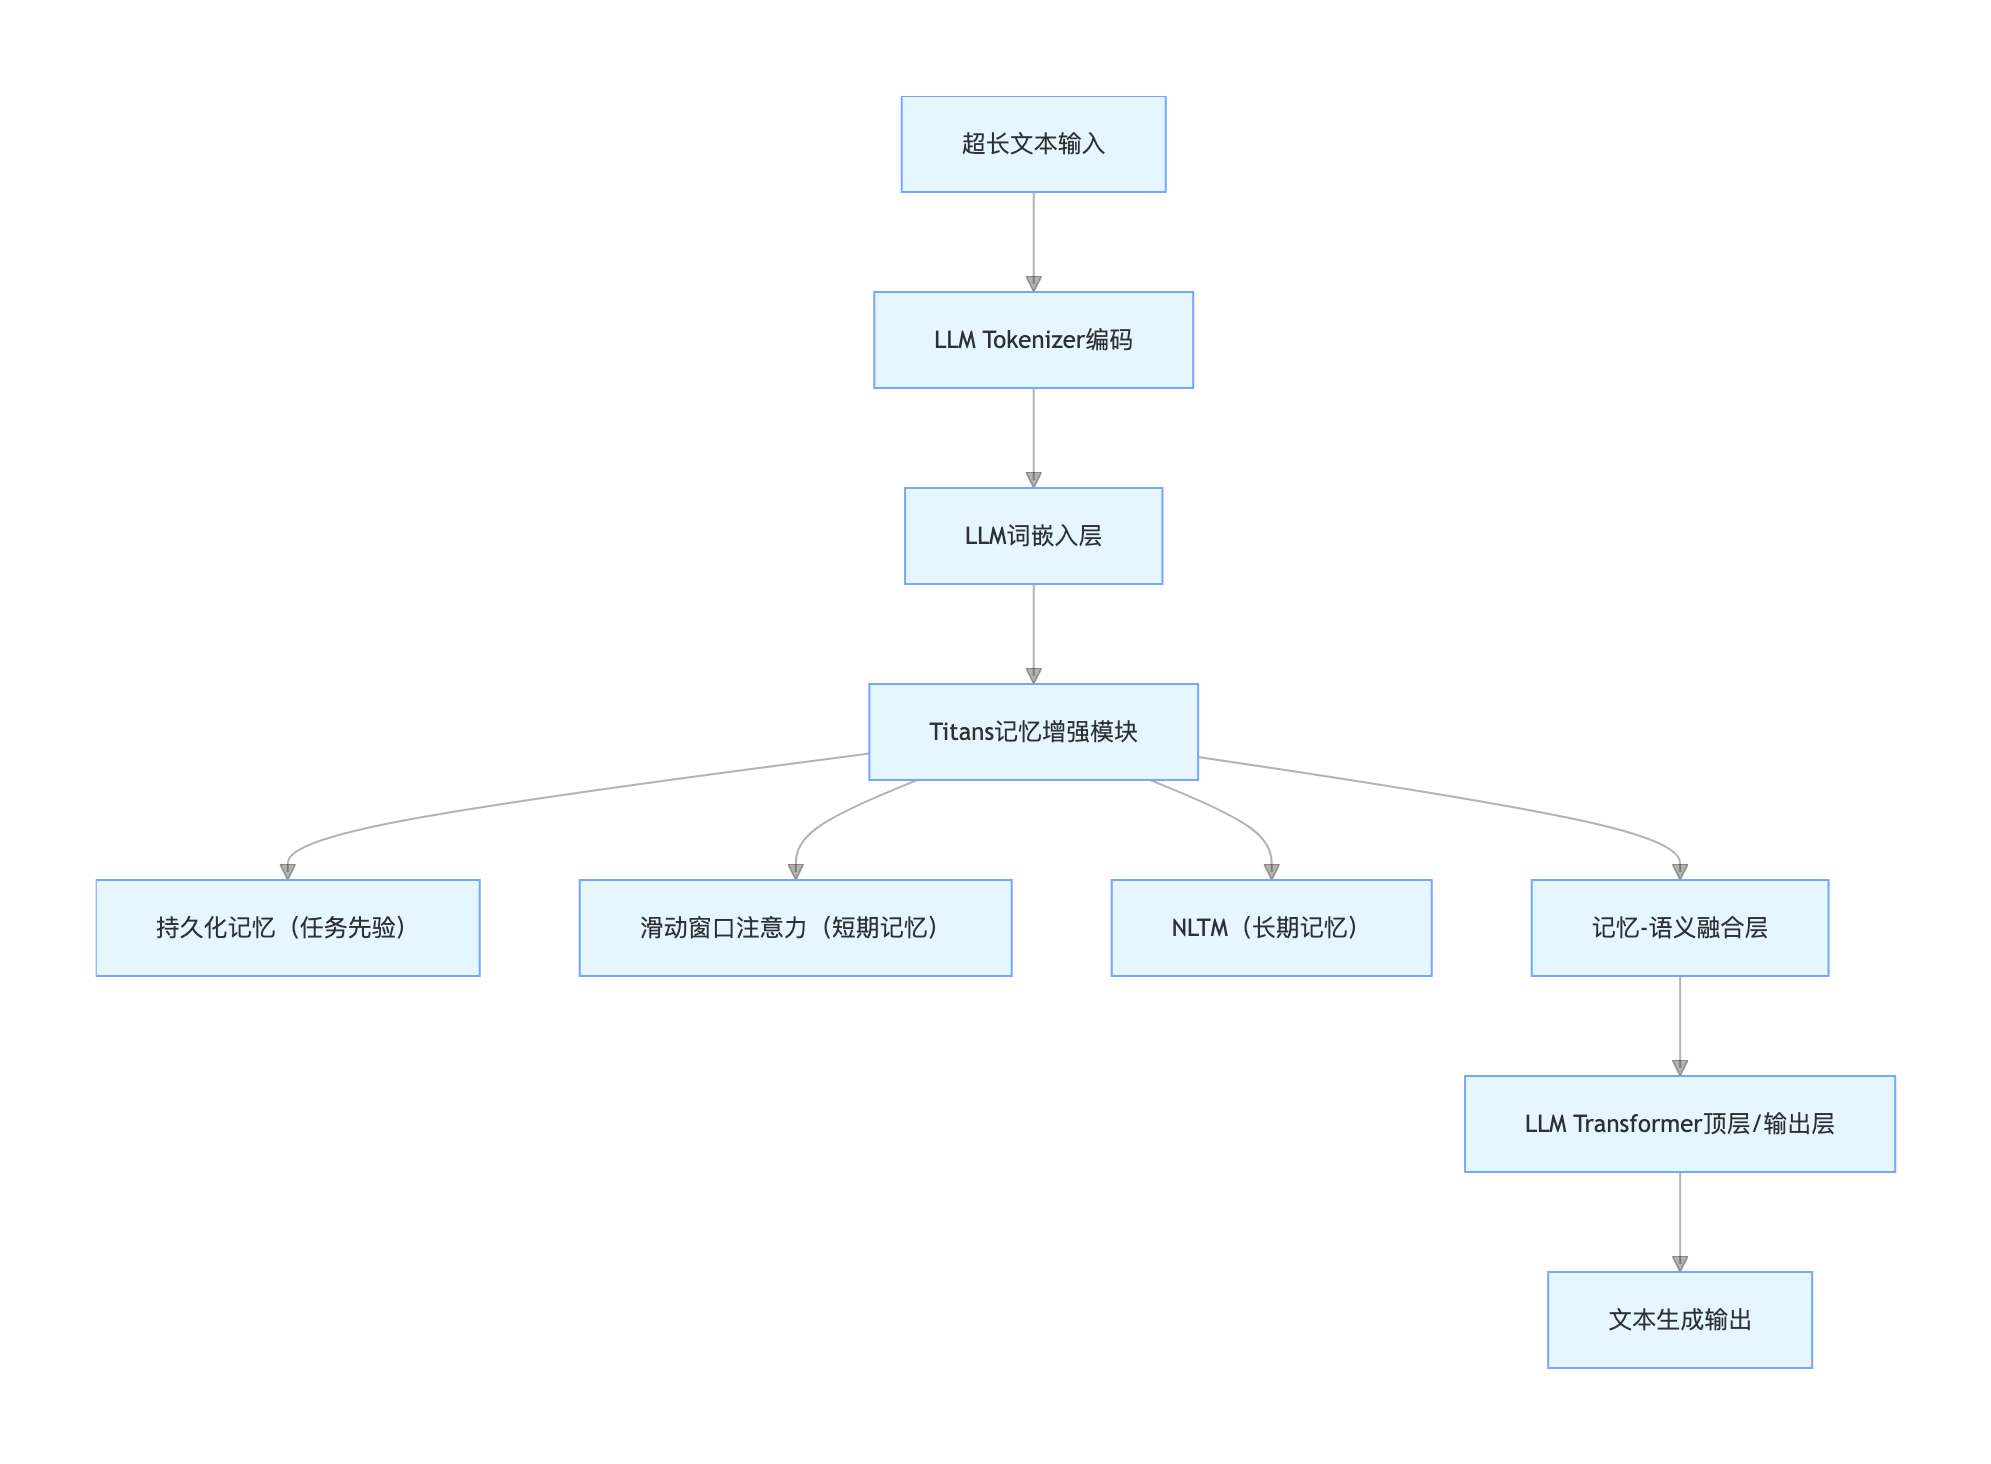

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, 
    GPT2Config, GPT2LMHeadModel,
    DataCollatorForLanguageModeling,
    get_scheduler
)
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 全局超参数
LLM_MODEL_NAME = "gpt2"  # 基础LLM，可替换为Llama-2、Baichuan等
D_MODEL = 768 if "gpt2" in LLM_MODEL_NAME else 4096  # 匹配LLM嵌入维度
SEQ_LEN = 512  # 适配长上下文
BATCH_SIZE = 2
EPOCHS = 3
LR = 5e-5   # 降低学习率1e-4 --> 5e-5
GRAD_CLIP_NORM = 0.5  # 降低梯度裁剪阈值

In [ ]:
# 本地模型路径
gpt2_model_path = "/ai/shenwei/workspace/Models/huggingface/gpt2"
# 本地数据集路径
dataset_path = "/ai/LLM_DATA/huggingface/wikitext"

## 方案 1：插件式集成（最快落地）
### 核心原理
将 Titans 记忆模块作为后置插件，接收 LLM 的词嵌入输出，生成 “记忆增强嵌入” 后与原嵌入融合，再送入 LLM 后续层。

In [ ]:
# Titans 记忆插件定义
class TitansMemoryPlugin(nn.Module):
    """Titans记忆插件：适配LLM的词嵌入维度"""
    def __init__(self, d_model: int, hidden_dim: int = 512, window_size: int = 128):
        super().__init__()
        self.d_model = d_model
        self.window_size = window_size
        
        # 1. 持久化记忆（任务级先验）
        self.persistent_memory = nn.Parameter(torch.randn(1, 4, d_model, device=device) * 0.01)  # 初始化缩放，防止初始值过大
        
        # 2. 滑动窗口注意力（短期记忆）
        self.window_attn = nn.MultiheadAttention(
            d_model, 
            num_heads=4,  # TODO
            batch_first=True,
            device=device
        )
        self.attn_norm = nn.LayerNorm(d_model, device=device)
        self.attn_dropout = nn.Dropout(0.05)
        
        # 3. NLTM（长期记忆）
        self.forget_gate = nn.Parameter(torch.tensor(0.9, device=device) * 0.1)  # 遗忘系数
        self.surprise_momentum = 0.9
        self.running_surprise = 0.0
        self.memory_mlp = nn.Sequential(
            nn.Linear(d_model, hidden_dim, device=device),
            nn.LayerNorm(hidden_dim, device=device),
            nn.GELU(),
            nn.Linear(hidden_dim, d_model, device=device),
            nn.LayerNorm(d_model, device=device)
        )
        self.memory = torch.zeros(1, 1, d_model, device=device, requires_grad=False)
        
        # 4. 记忆-语义融合门控
        self.fusion_gate = nn.Sequential(
            nn.Linear(2 * d_model, d_model, device=device),
            nn.LayerNorm(d_model, device=device),
            nn.Sigmoid()
        )

    def compute_surprise(self, x: torch.Tensor, x_pred: torch.Tensor) -> torch.Tensor:
        """计算惊喜度（无梯度）"""
        with torch.no_grad():
            surprise = torch.norm(x - x_pred, dim=-1, keepdim=True)
            self.running_surprise = self.surprise_momentum * self.running_surprise + (1 - self.surprise_momentum) * surprise.mean().item()
        return surprise

    def update_long_memory(self, x: torch.Tensor, x_pred: torch.Tensor) -> torch.Tensor:
        """更新长期记忆（NLTM核心）"""
        batch_size, seq_len, _ = x.shape
        
        # 惊喜度与重要性权重
        surprise = self.compute_surprise(x, x_pred)
        importance = torch.sigmoid(surprise)
        
        # 遗忘门控
        forget_weight = torch.sigmoid(self.forget_gate)
        memory_decay = 1 - forget_weight * importance
        
        # 压缩当前信息
        x_compressed = self.memory_mlp(x)
        
        # 广播记忆
        with torch.no_grad():
            expanded_memory = self.memory.expand(batch_size, seq_len, -1).clone()
        
        # 更新记忆
        updated_memory = expanded_memory * memory_decay + x_compressed * importance
        
        # 同步记忆状态
        with torch.no_grad():
            self.memory = updated_memory.mean(dim=(0,1), keepdim=True).clone()
        
        return updated_memory

    def sliding_window_attention(self, x: torch.Tensor) -> torch.Tensor:
        """滑动窗口注意力（短期记忆）"""
        batch_size, seq_len, _ = x.shape
        output = []
        
        for i in range(0, seq_len, self.window_size):
            window = x[:, i:i+self.window_size, :]
            attn_out, _ = self.window_attn(window, window, window)
            window_out = self.attn_norm(attn_out + window)
            output.append(window_out)
        
        return torch.cat(output, dim=1)

    def forward(self, llm_embeds: torch.Tensor, llm_pred_embeds: torch.Tensor) -> torch.Tensor:
        """
        前向传播：
        - llm_embeds: LLM词嵌入 [B, T, d_model]
        - llm_pred_embeds: LLM预测嵌入 [B, T, d_model]
        返回：记忆增强嵌入 [B, T, d_model]
        """
        batch_size = llm_embeds.shape[0]

        # 对输入嵌入进行缩放，防止数值过大
        llm_embeds = torch.clamp(llm_embeds, min=-10.0, max=10.0)
        llm_pred_embeds = torch.clamp(llm_pred_embeds, min=-10.0, max=10.0)
        
        # 1. 持久化记忆拼接
        persistent = self.persistent_memory.expand(batch_size, -1, -1)  # [B, 4, d_model]
        llm_embeds_with_persist = torch.cat([persistent, llm_embeds], dim=1)  # [B, T+4, d_model]
        
        # 2. 短期记忆（滑动窗口注意力）
        short_mem = self.sliding_window_attention(llm_embeds_with_persist)
        short_mem = short_mem[:, 4:, :]  # 移除持久化token
        
        # 3. 长期记忆（NLTM）
        long_mem = self.update_long_memory(llm_embeds, llm_pred_embeds)
        
        # 4. 记忆融合
        gate = self.fusion_gate(torch.cat([llm_embeds, short_mem + long_mem], dim=-1))
        fused_embeds = gate * llm_embeds + (1 - gate) * (short_mem + long_mem)

        # 对输出进行裁剪，防止数值过大溢出
        
        return fused_embeds

In [ ]:
class LLMWithTitansPlugin(nn.Module):
    """集成Titans插件的LLM"""
    def __init__(self, llm_model, titans_plugin):
        super().__init__()
        self.llm = llm_model
        self.titans_plugin = titans_plugin
        self.d_model = self.llm.config.n_embd
        
        # 预测嵌入层（将LLM logits映射回d_model维度）
        self.pred_emb_layer = nn.Sequential(
            nn.Linear(self.llm.config.vocab_size, self.d_model, device=device),
            nn.LayerNorm(self.d_model, device=device),
            nn.GELU()
        )

    def forward(self, input_ids, labels=None):
        """
        前向传播：兼容HuggingFace LLM接口
        """
        # 1. LLM基础前向（获取词嵌入）
        llm_outputs = self.llm.transformer.wte(input_ids)  # 词嵌入 [B, T, d_model]
        pos_emb = self.llm.transformer.wpe(torch.arange(input_ids.shape[1], device=device))
        llm_embeds = llm_outputs + pos_emb
        
        # 2. 生成LLM预测嵌入（模拟x_pred_emb）
        # 先过一层MLP得到logits，再映射回嵌入维度
        temp_hidden = self.llm.transformer.h[0](llm_embeds)[0]
        temp_logits = self.llm.lm_head(temp_hidden)
        llm_pred_embeds = self.pred_emb_layer(temp_logits)
        
        # 3. Titans记忆增强
        fused_embeds = self.titans_plugin(llm_embeds, llm_pred_embeds)
        
        # 4. 送入LLM后续层
        for layer in self.llm.transformer.h[1:]:
            fused_embeds = layer(fused_embeds)[0]
        
        # 5. 最终logits
        logits = self.llm.lm_head(fused_embeds)
        
        # 计算损失（兼容训练）
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.reshape(-1, logits.shape[-1]), labels.reshape(-1))
        
        return {"logits": logits, "loss": loss}

In [ ]:
def load_long_text_dataset(seq_len=SEQ_LEN):
    """加载WikiText-103超长文本数据集"""
    # 加载数据集
    if not os.path.exists(dataset_path):
        dataset = load_dataset("wikitext", "wikitext-103-v1", split="train[:10%]")  # 取10%数据加速训练
    else:  # 加载本地数据集
        dataset = load_dataset(f"{dataset_path}/wikitext-103-v1", split="train[:10%]")  # 取10%数据加速训练

    # 检查数据集路径
    print(f"数据集路径：{dataset_path}")
    print(f"数据集大小：{len(dataset)}")

    if not os.path.exists(gpt2_model_path):
        tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_NAME)
    else:
        tokenizer = AutoTokenizer.from_pretrained(gpt2_model_path)
    tokenizer.pad_token = tokenizer.eos_token

    PAD_TOKEN_ID = tokenizer.pad_token_id
    EOS_TOKEN_ID = tokenizer.eos_token_id
    
    # 预处理函数
    def preprocess_function(examples):
        # 编码文本
        texts = [t for t in examples["text"] if len(t.strip()) > 0]
        if not texts:
            return {"input_ids": [], "labels": []}
        encodings = tokenizer(
            texts,
            truncation=True,
            max_length=seq_len,
            padding="max_length",
            return_overflowing_tokens=False,
            add_special_tokens=False,
            # return_tensors="pt"
        )
        # 处理标签：确保无无效值，pad token 对应标签设为 -100（CrossEntropyLoss 忽略）
        labels = []
        for input_id in encodings["input_ids"]:
            # 标签移位：确保模型学习“预测下一个Token”
            label = input_id[1:] + [PAD_TOKEN_ID]  # 标签向后移位一位
            # 处理Pad Token，避免损失计算干扰
            label = [l if l != PAD_TOKEN_ID else -100 for l in label]
            labels.append(label)
        
        encodings["labels"] = labels
        return encodings
    
    # 应用预处理
    tokenized_dataset = dataset.map(
        preprocess_function,
        batched=True,
        remove_columns=dataset.column_names,
        desc="预处理文本"
    )
    tokenized_dataset = tokenized_dataset.filter(
        lambda x: len(x["input_ids"]) > 0,  # 过滤空样本
        desc="过滤无效样本"
    )
    tokenized_dataset.set_format("torch")
    
    # 数据加载器
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    dataloader = DataLoader(
        tokenized_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=data_collator,
        pin_memory=True
    )
    
    return dataloader, tokenizer

In [ ]:
@torch.no_grad()
def generate_with_titans(model, tokenizer, prompt, max_len=100, temperature=0.8, top_k=30):
    """推理函数：生成带Titans记忆增强的文本"""
    model.eval()
    # 递归设置子模块Eval模式（针对嵌套模型，如LLMWithTitansPlugin）
    for module in model.children():
        module.eval()

    PAD_TOKEN_ID = tokenizer.pad_token_id
    EOS_TOKEN_ID = tokenizer.eos_token_id

    ori_prompt = prompt
    
    # 编码提示
    try:
        input_ids = tokenizer.encode(
            prompt,
            return_tensors="pt",
            add_special_tokens=False
        ).to(device)
    except Exception as e:
        print(f"编码失败：{e}")
        return ori_prompt
    
    if input_ids.shape[1] == 0:
        print("空提示文本，直接返回")
        return ori_prompt
    generated_ids = input_ids.clone()
    prompt_len = generated_ids.shape[1]
    
    # 重置Titans记忆
    # model.titans_plugin.running_surprise = 0.0
    # model.titans_plugin.memory = torch.zeros(1, 1, D_MODEL, device=device, requires_grad=False)
    if hasattr(model, "titans_plugin"):
        model.titans_plugin.running_surprise = 0.0
        model.titans_plugin.memory = torch.zeros(
            1, 1, model.titans_plugin.d_model,
            device=device,
            requires_grad=False
        )
        # 若有其他记忆参数，一并重置
        if hasattr(model.titans_plugin, "persistent_memory"):
            model.titans_plugin.persistent_memory.requires_grad = False  # 推理时冻结
    # 若为层替换模型，重置所有层的NLTM记忆
    elif hasattr(model, "gpt2") and hasattr(model.gpt2.transformer, "h"):
        for layer in model.gpt2.transformer.h:
            if hasattr(layer, "nltm"):
                layer.nltm.memory = torch.zeros(
                    1, 1, model.config.n_embd,
                    device=device,
                    requires_grad=False
                )
    
    # 自回归生成
    for step in tqdm(range(max_len), desc="生成文本"):
        # 防止序列过长，仅取最后 SEQ_LEN 个 token 输入模型
        input_seq = generated_ids[:, -min(SEQ_LEN, generated_ids.shape[1]):]

        # 前向传播，获取 logits
        outputs = model(input_ids=input_seq)
        logits = outputs["logits"]

        # 关键修复：确保获取最后一个 token 的 logits（维度：[1, vocab_size]）
        if logits.dim() != 2 and logits.dim() != 3:
            print(f"logits 维度异常：{logits.shape}，跳过当前步")
            continue

        if logits.dim() == 3:
            last_logits = logits[:, -1, :].squeeze(1)  # 正确取最后一个 token 的 logits
        else:
            last_logits = logits  # 兼容特殊情况

        # 温度缩放：防止 temperature 为 0 导致数值异常
        if temperature <= 1e-4:
            temperature = 0.1  # 最小温度限制
        last_logits = last_logits / temperature

        # 4. 正确进行 Top-K 采样（核心修复：解决采样错误）
        next_token = None
        vocab_size = tokenizer.vocab_size
        # 校验Top-K合理性
        top_k = min(top_k, vocab_size - 1)  # 避免Top-K超过词汇表大小
        if top_k > 0:
            # Top-K采样：保留前top_k个候选Token
            top_k_values, top_k_indices = torch.topk(last_logits, top_k, dim=-1)
            # 计算概率并采样
            probs = torch.softmax(top_k_values, dim=-1)
            # 强制采样（避免取固定索引）
            next_token_idx = torch.multinomial(probs, num_samples=1)
            # 正确映射回原Token ID
            next_token = top_k_indices.gather(-1, next_token_idx)
        else:
            # 贪婪采样：取概率最大的Token
            next_token = last_logits.argmax(dim=-1, keepdim=True)

        # 5. 校验 next_token 有效性，避免无效 token
        if next_token is None or next_token.shape != (1, 1):
            next_token = torch.tensor([[EOS_TOKEN_ID]], device=device, dtype=torch.long)

        # 6. 优化终止条件：仅当 next_token 是 eos token 时终止（关键修复：避免过早停止）
        if next_token.item() == EOS_TOKEN_ID:
            print(f"生成到第 {step} 步，检测到 eos token，终止生成")
            break

        # 7. 拼接生成的 token（核心修复：确保序列增长）
        try:
            generated_ids = torch.cat([generated_ids, next_token], dim=1)  # 按列拼接，序列增长
        except Exception as e:
            print(f"Token拼接失败：{e}，当前generated_ids形状：{generated_ids.shape}，next_token形状：{next_token.shape}")
            break

        # 9. 强制终止条件：确保生成新内容
        generated_len = generated_ids.shape[1] - prompt_len
        if generated_len >= max_len:
            print(f"已生成{generated_len}个新Token，达到最大长度，终止生成")
            break

    # 7. 解码生成文本：优化解码逻辑，避免特殊Token干扰
    try:
        generated_text = tokenizer.decode(
            generated_ids[0],
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True
        )
    except Exception as e:
        print(f"解码失败：{e}")
        generated_text = ori_prompt

    # 8. 二次校验：若生成文本与原Prompt一致，强制重新生成
    if generated_text.strip() == ori_prompt.strip():
        print("警告：生成文本与原Prompt一致，尝试调整参数重新生成")
        # 调整参数：提高温度（增加随机性），扩大Top-K（增加采样范围）
        generated_text = generate_with_titans(
            model, tokenizer, ori_prompt,
            max_len=max_len,
            temperature=min(temperature + 0.4, 2.0),  # 温度不超过2.0，避免生成乱码
            top_k=min(top_k + 20, 100)  # Top-K不超过100
        )

    return generated_text

In [ ]:
# 训练与推理
def validate_generation(model, tokenizer, prompt, epoch):
    """训练过程中验证生成能力"""
    model.eval()
    with torch.no_grad():
        generated_text = generate_with_titans(model, tokenizer, prompt, max_len=50)
    is_valid = generated_text.strip() != prompt.strip()
    print(f"\nEpoch {epoch} 生成验证：")
    print(f"原Prompt：{prompt}")
    print(f"生成文本：{generated_text}")
    print(f"生成有效：{is_valid}")
    print("-" * 50)
    model.train()  # 验证后切回训练模式
    return is_valid

# 1. 加载基础LLM
if not os.path.exists(gpt2_model_path):
    llm = GPT2LMHeadModel.from_pretrained(LLM_MODEL_NAME).to(device)
else:
    llm = GPT2LMHeadModel.from_pretrained(gpt2_model_path).to(device)
# 冻结LLM底层参数（仅训练插件）
for name, param in llm.named_parameters():
    if "h.0" not in name and "wte" not in name and "wpe" not in name:
        param.requires_grad = False

# 2. 初始化Titans插件
titans_plugin = TitansMemoryPlugin(d_model=D_MODEL).to(device)

# 3. 集成模型
model = LLMWithTitansPlugin(llm, titans_plugin).to(device)

# 4. 加载数据集
train_loader, tokenizer = load_long_text_dataset()

# 5. 训练配置
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_loader) * EPOCHS
)

# 6. 训练循环
model.train()
for epoch in range(EPOCHS):
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch_idx, batch in enumerate(pbar):
        optimizer.zero_grad(set_to_none=True)
        
        # 数据迁移
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        
        # 前向传播
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs["loss"]

        # 检测 loss 是否为 NaN，若为 NaN 则跳过当前批次
        if torch.isnan(loss):
            print(f"Warning: 批次{batch_idx}的损失为 NaN，跳过该批次")
            continue
        
        # 反向传播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP_NORM)
        optimizer.step()
        scheduler.step()
        
        # 进度更新
        batch_loss = loss.item()
        total_loss += batch_loss
        current_step = pbar.n + 1
        avg_loss = total_loss / current_step if current_step > 0 else 0.0
        pbar.set_postfix({"loss": f"{batch_loss:.4f}", "avg_loss": f"{avg_loss:.4f}"})
    
    # _epoch 平均损失检测
    epoch_avg_loss = total_loss / len(train_loader) if len(train_loader) > 0 else 0.0
    if torch.isnan(torch.tensor(epoch_avg_loss)):
        print(f"警告：Epoch {epoch+1} 平均损失为 NaN，请检查数据或模型")
    else:
        print(f"Epoch {epoch+1} 平均损失: {epoch_avg_loss:.4f}")
    
    # 每个Epoch结束后验证生成能力
    test_prompt = "In the field of artificial intelligence, long context understanding is crucial because "
    validate_generation(model, tokenizer, test_prompt, epoch+1)

In [ ]:
# 测试推理
prompt = "In the field of artificial intelligence, long context understanding is crucial because "
print(f"原提示：{prompt}")
generated_text = generate_with_titans(model, tokenizer, prompt, max_len=100, temperature=0.8, top_k=30)
print(f"生成文本：{generated_text}")
print(f"原提示长度：{len(prompt)}")
print(f"生成文本长度：{len(generated_text)}")
print(f"是否有效生成：{generated_text.strip() != prompt.strip()}")

## 方案 2：层替换集成（深度优化）
1. 核心原理
用 Titans 的「滑动窗口注意力 + NLTM」替换 LLM 中的全注意力层，从根本上降低注意力复杂度（O (T²)→O (T)），支持超长上下文。

In [ ]:
class TitansSlidingWindowAttention(nn.Module):
    """Titans 滑动窗口注意力：适配 LLM 接口"""
    def __init__(self, d_model, n_head, window_size, device):
        super().__init__()
        self.d_model = d_model
        self.n_head = n_head
        self.window_size = window_size
        self.device = device
        
        # 初始化滑动窗口注意力层
        self.self_attn = nn.MultiheadAttention(
            d_model, n_head, batch_first=True, device=device
        )
        self.norm = nn.LayerNorm(d_model, device=device)
        self.dropout = nn.Dropout(0.1)

    def forward(self, hidden_states, attention_mask=None, **kwargs):
        """兼容 GPT2 注意力层接口"""
        batch_size, seq_len, _ = hidden_states.shape
        output = []

        # 滑动窗口计算注意力
        for i in range(0, seq_len, self.window_size):
            window = hidden_states[:, i:i+self.window_size]
            window_mask = attention_mask[:, i:i+self.window_size] if attention_mask is not None else None
            attn_out, _ = self.self_attn(window, window, window, attn_mask=window_mask)
            window_out = self.dropout(self.norm(attn_out + window))
            output.append(window_out)
        
        attn_output = torch.cat(output, dim=1)
        return (attn_output, None)

In [ ]:
class NeuralLongTermMemory(nn.Module):
    """NLTM 层：适配 LLM 接口"""
    def __init__(self, d_model, hidden_dim, device):
        super().__init__()
        self.d_model = d_model
        self.device = device

        self.forget_gate = nn.Parameter(torch.tensor(0.9, device=device))
        self.memory_mlp = nn.Sequential(
            nn.Linear(d_model, hidden_dim, device=device),
            nn.LayerNorm(hidden_dim, device=device),
            nn.GELU(),
            nn.Linear(hidden_dim, d_model, device=device),
            nn.LayerNorm(d_model, device=device),
        )
        self.memory = torch.zeros(1, 1, d_model, device=device, requires_grad=False)

    def forward(self, x):
        """前向传播：更新记忆并返回增强特性"""
        batch_size, seq_len, _ = x.shape

        # 遗忘门控
        forget_weight = torch.sigmoid(self.forget_gate)
        memory_decay = 1 - forget_weight * 0.1  # 固定重要性权重

        # 压缩当前信息
        x_compressed = self.memory_mlp(x)

        # 广播记忆
        expanded_memory = self.memory.expand(batch_size, seq_len, -1)

        # 更新记忆
        updated_memory = expanded_memory * memory_decay + x_compressed * 0.9

        # 同步记忆
        with torch.no_grad():
            self.memory = updated_memory.mean(dim=(0,1), keepdim=True).clone()
        
        return x + updated_memory  # 残差连接

In [ ]:
# 替换 LLM 的注意力层
def replace_llm_attention(llm_model, window_size=128):
    """替换 LLM 的全注意力层为 Titans 滑动注意力"""
    d_model = llm_model.config.n_embd
    n_head = llm_model.config.n_head

    # 遍历所有 Transformer 层
    for i, layer in enumerate(llm_model.transformer.h):
        # 替换注意力层为滑动窗口注意力
        layer.attn = TitansSlidingWindowAttention(
            d_model=d_model,
            n_head=n_head,
            window_size=window_size,
            device=device,
        )

        # 新增 NLTM 层
        layer.nltm = NeuralLongTermMemory(
            d_model=d_model,
            hidden_dim=1024,
            device=device,
        )
    
    return llm_model
        

In [ ]:
# 修改 LLM 前向传播
class GPT2WithTitansAttention(nn.Module):
    """替换 GPT2 的注意力层"""
    def __init__(self, gpt2_model):
        super().__init__()
        self.gpt2 = gpt2_model
        self.config = self.gpt2.config

    def forward(self, input_ids, labels=None):
        
        embeds = self.gpt2.transformer.wte(input_ids)
        pos_embeds = self.gpt2.transformer.wpe(torch.arange(input_ids.shape[1], device=device))
        hidden_states = embeds + pos_embeds

        # 遍历 Transformers 层
        for layer in self.gpt2.transformer.h:
            # 滑动窗口注意力
            attn_output = layer.attn(hidden_states)[0]
            hidden_states = layer.ln_1(hidden_states + attn_output)

            # NLTM 长期记忆增强
            hidden_states = layer.nltm(hidden_states)

            # 前馈网络
            ffn_output = layer.mlp(hidden_states)
            hidden_states = layer.ln_2(hidden_states + ffn_output)

        # 输出层
        logits = self.gpt2.lm_head(hidden_states)

        # 损失计算
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.reshape(-1, logits.shape[-1]), labels.reshape(-1))

        return {"logits": logits, "loss": loss}

In [ ]:
# 1. 加载并修改LLM
if not os.path.exists(gpt2_model_path):
    llm = GPT2LMHeadModel.from_pretrained(LLM_MODEL_NAME).to(device)
else:
    llm = GPT2LMHeadModel.from_pretrained(gpt2_model_path).to(device)
llm = replace_llm_attention(llm, window_size=128)
model = GPT2WithTitansAttention(llm).to(device)

# 2. 冻结非注意力层参数（仅微调Titans层）
for name, param in model.named_parameters():
    if "attn" not in name and "nltm" not in name:
        param.requires_grad = False

# 3. 训练（复用方案1的数据集和训练逻辑）
train_loader, tokenizer = load_long_text_dataset()
optimizer = optim.AdamW(model.parameters(), lr=LR)

model.train()
for epoch in range(EPOCHS):
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in pbar:
        optimizer.zero_grad(set_to_none=True)

        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        
        # 前向传播
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs["loss"]

        # 检测 loss 是否为 NaN，若为 NaN 则跳过当前批次
        if torch.isnan(loss):
            print(f"Warning: 批次{batch_idx}的损失为 NaN，跳过该批次")
            continue
        
        # 反向传播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP_NORM)
        optimizer.step()
        scheduler.step()
        
        # 进度更新
        batch_loss = loss.item()
        total_loss += batch_loss
        current_step = pbar.n + 1
        avg_loss = total_loss / current_step if current_step > 0 else 0.0
        pbar.set_postfix({"loss": f"{batch_loss:.4f}", "avg_loss": f"{avg_loss:.4f}"})


In [ ]:

# 4. 推理（支持超长文本）
@torch.no_grad()
def generate_long_text(model, tokenizer, prompt, max_len=200):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    generated_ids = input_ids.clone()
    
    # 重置所有NLTM记忆
    for layer in model.gpt2.transformer.h:
        layer.nltm.memory = torch.zeros(1, 1, model.config.n_embd, device=device)
    
    for _ in range(max_len):
        outputs = model(input_ids=generated_ids)
        logits = outputs["logits"]
        next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
        generated_ids = torch.cat([generated_ids, next_token], dim=1)
        
        if next_token.item() == tokenizer.eos_token_id:
            break
    
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# 测试超长文本生成
long_prompt = "The development of artificial intelligence has gone through several stages. " * 50  # 超长提示
generated_text = generate_long_text(model, tokenizer, long_prompt)
print(f"生成文本长度: {len(tokenizer.encode(generated_text))}")
print(f"生成文本: {generated_text[:500]}...")

# 方案 3：端到端融合
1. 核心原理  
联合设计 LLM+Titans 架构，将 Titans 的记忆模块与 LLM 的 Transformer 层深度融合，重新定义前向传播逻辑。

In [ ]:
class TitansFusedLayer(nn.Module):
    """融合 Titans 记忆的 Transformers 层"""
    def __init__(self, d_model, n_head, window_size, device):
        super().__init__()
        # 滑动窗口注意力
        self.attn = TitansSlidingWindowAttention(d_model, n_head, window_size, device)
        # NLTM 长期记忆
        self.nltm = NeuralLongTermMemory(d_model, 1024, device)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.LayerNorm(d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(0.1)
        )

        self.ln_1 = nn.LayerNorm(d_model, device)
        self.ln_2 = nn.LayerNorm(d_model, device)
    
    def forward(self, x):
        # 注意力 + 残差
        attn_out = self.attn(x)[0]
        x = self.ln_1(x + attn_out)

        # NLTM 记忆增强
        x = self.nltm(x)

        # MLP + 残差
        mlp_out = self.mlp(x)
        x = self.ln_2(x + mlp_out)

        return x

In [ ]:
class TitansFusedLLM(nn.Module):
    """端到端融合的 Titans-LLM"""
    def __init__(self, vocab_size, d_model=768, n_layer=6, n_head=8, window_size=128):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model

        # 基础嵌入
        self.embedding = nn.Embedding(vocab_size, d_model, device=device)
        self.pos_embedding = nn.Embedding(1024, d_model, device=device)

        # 持久化记忆
        self.persistent_memory = nn.Parameter(torch.randn(1, 4, d_model, device=device))

        # Transformer 层
        self.layers = nn.ModuleList([
            TitansFusedLayer(d_model, n_head, window_size, device=device) for _ in range(n_layer)
        ])

        # 输出层
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, input_ids, labels=None):
        batch_size, seq_len = input_ids.shape

        # 基础嵌入
        embeds = self.embedding(input_ids)
        pos_embeds = self.pos_embedding(torch.arange(seq_len, device=device).unsqueeze(0))
        hidden_states = embeds + pos_embeds

        # 持久化记忆
        # 持久化记忆拼接
        persistent = self.persistent_memory.expand(batch_size, -1, -1)
        hidden_states = torch.cat([persistent, hidden_states], dim=1)

        # 遍历融合层 
        for layer in self.layers:
            hidden_states = layer(hidden_states)

        # 移除持久化 token
        hidden_states = hidden_states[:, 4:, :]

        # 输出 logits
        logits = self.lm_head(hidden_states)

        # 计算损失
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.reshape(-1, self.vocab_size), labels.reshape(-1))
        
        return {"loss": loss, "logits": logits}

# 关键优化技巧

In [ ]:
# 低资源适配(PEFT/LoRA)
# 使用 LoRA 微调 Titans 模块（降低显存占用)
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["self_attn", "nltm", "fusion_gate"]  # 仅微调 Titans 相关层
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # 查看可训练参数

In [ ]:
# 超长上下文优化
# 分段处理：将 10 万 token 文本分为多个 512 token 段，跨段传递记忆
def process_long_text(model, tokenizer, long_text, chunk_size=512):
    chunks = [long_text[i:i+chunk_size] for i in range(0, len(long_text), chunk_size)]
    memory_states = []

    for chunk in chunks:
        input_ids = tokenizer.encode(chunk, return_tensors="pt").to(device)
        outputs = model(input_ids=input_ids)

        # 保存当前段的记忆状态
        current_memory = [layer.nltm.memory for layer in model.gpt2.transformer.h]
        memory_states.append(current_memory)
        
        # 加载上一段的记忆状态（跨段传递）
        if len(memory_states) > 1:
            for i, layer in enumerate(model.gpt2.transformer.h):
                layer.nltm.memory = memory_states[-2][i]
    
    return memory_states

In [ ]:
# 缓存记忆状态：避免重复计算历史token的记忆
@torch.no_grad()
def generate_with_memory_cache(model, tokenizer, prompt, max_len=100):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    generated_ids = input_ids.clone()
    
    # 预计算初始记忆
    initial_memory = [layer.nltm.memory.clone() for layer in model.gpt2.transformer.h]
    
    for _ in range(max_len):
        # 仅计算最后一个token的记忆
        input_ids = generated_ids[:, -1:]
        outputs = model(input_ids=input_ids)
        
        # 恢复初始记忆（仅更新最后一个token）
        for i, layer in enumerate(model.gpt2.transformer.h):
            layer.nltm.memory = initial_memory[i]
        
        # 采样
        next_token = outputs["logits"][:, -1, :].argmax(dim=-1, keepdim=True)
        generated_ids = torch.cat([generated_ids, next_token], dim=1)
    
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

In [11]:
# 加载 gpt2 模型与 tokenizer
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_path).to(device)
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_path)

prompt = "In the field of artificial intelligence, long context understanding is crucial because "
# 只基于gpt2模型来完成文本生成
gpt2_output = gpt2_tokenizer.decode(gpt2_model.generate(tokenizer.encode(prompt, return_tensors="pt").to(device), max_length=100)[0])
print(gpt2_output)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In the field of artificial intelligence, long context understanding is crucial because  it allows us to understand the world in a way that is not possible with traditional cognitive science.
In the field of artificial intelligence, long context understanding is crucial because  it allows us to understand the world in a way that is not possible with traditional cognitive science.
In the field of artificial intelligence, long context understanding is crucial because  it allows us to understand the world in a way that is not possible with
